# Import

In [3]:
%matplotlib widget
# %matplotlib inline

In [4]:
import csv 
import os
import json
import pickle
import pandas as pd
import copy
from tqdm import tqdm

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pprint import pprint

# Set R_HOME Environment variable
import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter
from rpy2.robjects.vectors import StrVector

import scipy as sp
from scipy import stats
import seaborn as sns; sns.set()

from functools import reduce

# Define Functions

In [5]:
def install_mirt_packages(utils, packnames = ['mirt', 'psych']):
    utils.chooseCRANmirror(ind=1) # select the first mirror in the list
    
    # Selectively install what needs to be installed.
    names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
    if len(names_to_install) > 0:
        utils.install_packages(StrVector(names_to_install))
    
    print(f"Installed {len(names_to_install)} packages: {names_to_install}")

def get_mirt_packages(packnames = ['mirt', 'psych']):
    return {
        key: rpackages.importr(key)
        for key in packnames
    }
    
def import_lalor_responses(fname, ftype='csv'):
    if ftype == 'csv':
        return pd.read_csv(f"{fname}.{ftype}", index_col=0)
    else:
        raise TypeError(f"File type {ftype} not supported for Lalor responses.")

def get_mirt_wrapper(args):
    technical = ','.join([f'{key}={value}' for key, value in args.technical.items()])
    
    print(f"Technical list for MIRT is {technical}")
    
    ro.r(
        f'''
        f <- function(df, verbose = FALSE)  {{
            fitted <- mirt(df, {args.factors}, itemtype="{args.itemtype}", TOL={args.TOL}, technical=list({technical}))
            result <- coef(fitted, simplify=TRUE, IRTpar=TRUE)$items;
            return(data.frame(result))
        }}
        '''
    )
    
    return ro.globalenv['f']

def get_tetrachoric_R():
    ro.r(
        f'''
        t <- function(df) {{
            result <- tetrachoric(df)
            return(data.frame(result$rho))
        }}
        '''
    )
    
    return ro.globalenv['t']

# Run

## Set up R and Appropriate Packages

In [6]:
r_base = rpackages.importr('base')
r_utils = rpackages.importr('utils')

In [7]:
install_mirt_packages(r_utils)
imported = get_mirt_packages(packnames = ['mirt', 'psych'])

Installed 0 packages: []


In [8]:
tetr = get_tetrachoric_R()

## Set Args and Load Data

In [9]:
# choose prior ['vague', 'hierarchical']

args_dict = {
    'factors':1,
    'itemtype':"2PL",
    'TOL':1e-4,
    'optimizer':'NR',
    'technical':{
        'NCYCLES':1e4
    }
}

args = pd.Series(args_dict)

In [10]:
data_dir = os.path.dirname(os.path.abspath('__file__'))

## Factor Analysis

In [11]:
repo = os.path.join('..')
response_dir = os.path.join(repo, 'data')

In [12]:
model_data = {}

response_files = [f for f in os.listdir(response_dir) if os.path.isfile(os.path.join(response_dir, f))]

print(len(response_files))
pprint(response_files)

for response_file in response_files:
    dataset = response_file.split('_irt_all_coded.csv')[0]
    model_data[dataset] = import_lalor_responses(os.path.join(response_dir,f'{dataset}_irt_all_coded'), ftype='csv')

df_all_data = [model_data[key] for key in model_data]

model_data['combined'] = reduce(lambda left, right: pd.DataFrame.join(left, right), df_all_data)

print(model_data['combined'].shape)

28
['abductive-nli_irt_all_coded.csv',
 'arc-challenge_irt_all_coded.csv',
 'arc-easy_irt_all_coded.csv',
 'arct_irt_all_coded.csv',
 'boolq_irt_all_coded.csv',
 'cb_irt_all_coded.csv',
 'commonsenseqa_irt_all_coded.csv',
 'copa_irt_all_coded.csv',
 'cosmosqa_irt_all_coded.csv',
 'hellaswag_irt_all_coded.csv',
 'mcscript_irt_all_coded.csv',
 'mctaco_irt_all_coded.csv',
 'mnli_irt_all_coded.csv',
 'mrqa-nq_irt_all_coded.csv',
 'mutual-plus_irt_all_coded.csv',
 'mutual_irt_all_coded.csv',
 'newsqa_irt_all_coded.csv',
 'piqa_irt_all_coded.csv',
 'qamr_irt_all_coded.csv',
 'quail_irt_all_coded.csv',
 'quoref_irt_all_coded.csv',
 'rte_irt_all_coded.csv',
 'snli_irt_all_coded.csv',
 'socialiqa_irt_all_coded.csv',
 'squad-v2_irt_all_coded.csv',
 'wic_irt_all_coded.csv',
 'winogrande_irt_all_coded.csv',
 'wsc_irt_all_coded.csv']
(90, 79033)


In [14]:
model_data['combined'].to_csv(os.path.join(response_dir, 'combined_irt_all_coded.csv'))

In [ ]:
with localconverter(ro.default_converter + pandas2ri.converter):
    cov = tetr(model_data['combined'])

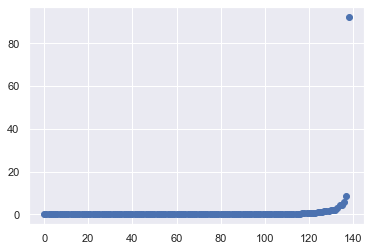

In [22]:
cov_eigs = np.linalg.eigvalsh(cov)

plt.scatter(list(range(len(cov_eigs))),cov_eigs)